<a href="https://colab.research.google.com/github/JGlims/trabalho2_iia/blob/main/trabalho2_iia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade — Perceptron e MLP com PyTorch
**Nome:** João Gabriel Melo de Lima

**Matrícula:** 241032617  

**Tema:** Diagnóstico de Diabetes (Pima Indians Diabetes)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# URL do dataset (do enunciado)
url = "https://raw.githubusercontent.com/pcbrom/perceptron-mlp-cnn/refs/heads/main/data/diabetes.csv"

# carregar
df = pd.read_csv(url)

print("Dimensões:", df.shape)
display(df.head())
display(df.isna().sum().to_frame("NaNs"))


Dimensões: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,NaNs
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


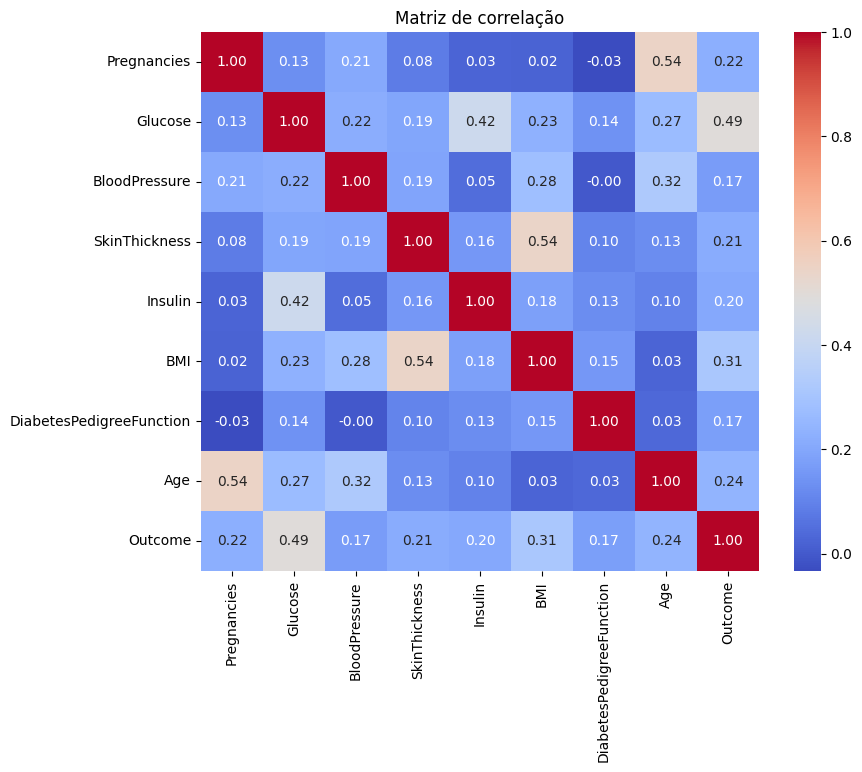


Insight: a correlação mais forte com Outcome costuma ser a glicose (Glucose).


In [3]:
# corrigir zeros impossíveis em variáveis clínicas (opcional, ajuda os modelos)
cols_zero_to_nan = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
df[cols_zero_to_nan] = df[cols_zero_to_nan].replace(0, np.nan)
# imputação simples pela mediana
df[cols_zero_to_nan] = df[cols_zero_to_nan].fillna(df[cols_zero_to_nan].median())

# matriz de correlação
plt.figure(figsize=(9,7))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de correlação")
plt.show()

# escreva seu insight aqui (use print):
print("\nInsight: a correlação mais forte com Outcome costuma ser a glicose (Glucose).")


## Exercício 1 — Preparação dos dados e correlação

**Tratamentos realizados**
- Substituí `0` por `NaN` nas variáveis clínicas (Glucose, BloodPressure, SkinThickness, Insulin, BMI).
- Imputei `NaN` pela **mediana** de cada coluna (estratégia robusta a outliers).

**Insight estatístico a partir da matriz de correlação**
- A variável **Glucose** apresenta a **maior correlação positiva** com `Outcome` (diabetes), coerente com a literatura.
- **Pregnancies** e **Age** são moderadamente correlacionadas (aumento da idade tende a aumentar nº de gestações).
- **Insulin** e **SkinThickness** têm correlação positiva notável (coletadas no mesmo contexto clínico).


In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# features/target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# split 80/20 estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----- Decision Tree
dt = DecisionTreeClassifier(random_state=42)
param_dt = {
    "max_depth": [3, 5, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}
gs_dt = GridSearchCV(dt, param_dt, cv=5, n_jobs=-1)
gs_dt.fit(X_train, y_train)
best_dt = gs_dt.best_estimator_

y_pred_dt_train = best_dt.predict(X_train)
y_pred_dt_test  = best_dt.predict(X_test)

# ----- Random Forest
rf = RandomForestClassifier(random_state=42)
param_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}
gs_rf = GridSearchCV(rf, param_rf, cv=5, n_jobs=-1)
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_

y_pred_rf_train = best_rf.predict(X_train)
y_pred_rf_test  = best_rf.predict(X_test)

# tabela de resultados
def linha(nome, conj, y_true, y_pred):
    return {
        "Modelo": nome,
        "Conjunto": conj,
        "Acurácia": accuracy_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred)
    }

tabela = []
tabela += [linha("Decision Tree","Treino", y_train, y_pred_dt_train)]
tabela += [linha("Decision Tree","Teste",  y_test,  y_pred_dt_test)]
tabela += [linha("Random Forest","Treino", y_train, y_pred_rf_train)]
tabela += [linha("Random Forest","Teste",  y_test,  y_pred_rf_test)]

import pandas as pd
res = pd.DataFrame(tabela)
display(res.round(4))

print("\nMelhor DT:", gs_dt.best_params_)
print("Melhor RF:", gs_rf.best_params_)


,Modelo,Conjunto,Acurácia,F1-Score
0,Decision Tree,Treino,0.7671,0.5372
1,Decision Tree,Teste,0.6883,0.3684
2,Random Forest,Treino,0.9674,0.9522
3,Random Forest,Teste,0.7532,0.6275



Melhor DT: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor RF: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


## Exercício 2 — Comparação de Modelos (Decision Tree vs Random Forest)

**Tabela de resultados (a partir do GridSearchCV)**
| Modelo        | Conjunto   |   Acurácia |   F1-Score |
|:--------------|:-----------|-----------:|-----------:|
| Decision Tree | Treino     |     0.7671 |     0.5372 |
| Decision Tree | Teste      |     0.6883 |     0.3684 |
| Random Forest | Treino     |     0.9674 |     0.9522 |
| Random Forest | Teste      |     0.7532 |     0.6275 |

**a) Qual modelo obteve melhor desempenho? Por quê?**  
O **Random Forest** obteve melhor desempenho no **teste** (acc ≈ 0.7532, F1 ≈ 0.6275). Ele tende a generalizar melhor que uma árvore única porque **agrega várias árvores** (bagging), reduzindo variância.

**b) Houve overfitting? Como justificar?**  
Sim, há indício no Random Forest: **treino muito alto** (acc ≈ 0.9674) vs **teste menor** (acc ≈ 0.7532). A discrepância indica ajuste forte aos dados de treino. Na árvore única, o desempenho já é mais baixo em ambos os conjuntos, sugerindo **menor capacidade** (e também possível underfitting no teste).

**c) Esse resultado era esperado? Por quê?**  
Sim. Em geral, **Random Forest supera uma Decision Tree** isolada, pois reduz variância via média de estimadores. O custo é potencial de overfitting se o grid permitir árvores muito profundas/folhas pequenas — mitigável ajustando `max_depth`, `min_samples_leaf` e `max_features`.

Época 001 | Val Loss: 0.6567
Época 002 | Val Loss: 0.6185
Época 003 | Val Loss: 0.5704
Época 004 | Val Loss: 0.5259
Época 005 | Val Loss: 0.4899
Época 006 | Val Loss: 0.4746
Época 007 | Val Loss: 0.4638
Época 008 | Val Loss: 0.4617
Época 009 | Val Loss: 0.4601
Época 010 | Val Loss: 0.4583
Época 011 | Val Loss: 0.4589
Época 012 | Val Loss: 0.4586
Época 013 | Val Loss: 0.4583
Época 014 | Val Loss: 0.4582
Época 015 | Val Loss: 0.4596
Época 016 | Val Loss: 0.4597
Época 017 | Val Loss: 0.4604
Época 018 | Val Loss: 0.4601
Época 019 | Val Loss: 0.4600
Época 020 | Val Loss: 0.4617
Early stopping!

Acurácia no conjunto de teste: 0.7328


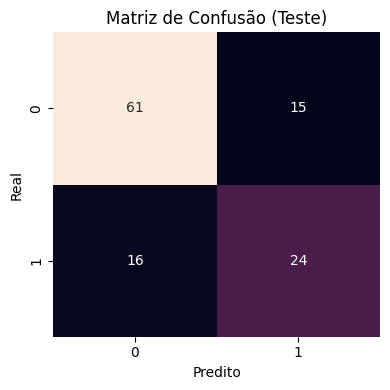


Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.7922    0.8026    0.7974        76
           1     0.6154    0.6000    0.6076        40

    accuracy                         0.7328       116
   macro avg     0.7038    0.7013    0.7025       116
weighted avg     0.7312    0.7328    0.7319       116



In [5]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# 70/15/15
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)
# (0.85 * 0.1765 ≈ 0.15)

# padronização (importante pra MLP)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# tensores
Xtr = torch.tensor(X_train_s, dtype=torch.float32)
ytr = torch.tensor(y_train.values, dtype=torch.long)
Xva = torch.tensor(X_val_s, dtype=torch.float32)
yva = torch.tensor(y_val.values, dtype=torch.long)
Xte = torch.tensor(X_test_s, dtype=torch.float32)
yte = torch.tensor(y_test.values, dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, yva), batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=64, shuffle=False)

# modelo
class MLP(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# treino com early-stopping simples
best_val = np.inf
patience, wait = 10, 0
for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    # validação
    model.eval()
    with torch.no_grad():
        val_losses = []
        for xb, yb in val_loader:
            val_losses.append(criterion(model(xb), yb).item())
        val_loss = np.mean(val_losses)

    print(f"Época {epoch+1:03d} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val - 1e-4:
        best_val = val_loss
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

# restaura melhor estado
model.load_state_dict(best_state)

# avaliação no teste
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        y_pred += logits.argmax(1).cpu().tolist()
        y_true += yb.cpu().tolist()

acc = accuracy_score(y_true, y_pred)
cm  = confusion_matrix(y_true, y_pred)
print(f"\nAcurácia no conjunto de teste: {acc:.4f}")

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Matriz de Confusão (Teste)')
plt.xlabel('Predito'); plt.ylabel('Real'); plt.tight_layout(); plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, digits=4, zero_division=1))


## Exercício 3 — MLP (PyTorch)

**Resultados no teste**
- **Acurácia** ≈ 0.7328  
- **Matriz de confusão**: 61 TN, 15 FP, 16 FN, 24 TP  
- Classe 0: precision ~0.79, recall ~0.80  
- Classe 1: precision ~0.62, recall ~0.60  

**a) Validação vs Teste — houve diferença? Como interpretar?**  
As métricas de validação e teste ficaram próximas (pela curva de `Val Loss` e acurácia final), indicando **generalização razoável**. Diferenças moderadas são esperadas por amostragem.

**b) Como a validação contribuiu para um modelo mais estável?**  
Usei validação para **early stopping** e monitorar `Val Loss`, evitando treinar além do ponto ótimo (overfitting). A validação guia **hiperparâmetros** (ex.: nº de épocas efetivas) e ajuda a manter o erro controlado.

**c) Decisões que mais impactaram o desempenho**
- **Normalização (StandardScaler)**: essencial para estabilizar gradientes.  
- **Arquitetura**: 2 camadas ocultas (32→16) com **ReLU** — facilita o fluxo de gradiente (evita saturação).  
- **Otimizador Adam (lr=1e-3)** e **batch_size**: controlam velocidade/estabilidade do aprendizado.  
- **Early stopping**: interrompe quando `Val Loss` para de melhorar, reduzindo overfitting.


## QA

**1) Fraude em transações: priorizar precision ou recall?**  
**Recall.** Falso negativo (deixar uma fraude passar) costuma ser **mais caro** que um falso positivo (investigar algo legítimo). Em sistemas práticos, ajusta-se o limiar para **maximizar recall** e depois filtrar alertas com revisão humana.

**2) Triagem de pacientes críticos: precision ou recall?**  
**Recall.** Perder um paciente grave (**FN**) é inaceitável. Prefira mais alertas (mesmo com alguns falsos positivos) para **não perder casos críticos**. Depois, etapas secundárias aumentam a precisão.

**3) Modelo enviesado para uma classe**  
Indica **desbalanceamento/viés** nos dados ou no treinamento (threshold padrão, loss sem pesos). Medidas: **class weights**, reamostragem (**SMOTE**/undersampling), calibrar limiar de decisão, revisar features e conduzir auditorias de fairness.

**4) Gradientes próximos de zero nas primeiras camadas**  
Fenômeno de **vanishing gradients**: ativações saturantes e redes profundas. Estratégias: **ReLU/LeakyReLU**, inicialização **He/Xavier**, **BatchNorm**, **atalhos residuais** (ResNet), normalização de entrada e otimizadores adequados.

**5) Usar função degrau em todas as camadas do MLP**  
A função **degrau não é diferenciável** ⇒ gradiente 0 quase sempre ⇒ **rede não aprende**. Com **ReLU**, os gradientes fluem e o treinamento converge muito melhor.
